In [138]:
import jupedsim as jps
import pedpy
import read_geometry as rr
from shapely import Polygon, to_wkt, Point, LinearRing, intersection
import pathlib
from numpy.random import normal
import random
import numpy as np
from typing import List
import matplotlib.pyplot as plt
#from jupedsim.internal.notebook_utils import animate, read_sqlite_file
import random
from joblib import Parallel, delayed
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy

In [139]:
wkt = rr.parse_geo_file("./Jaleanwala_Bagh.xml")

In [140]:
# simulation might start with less than that, cause we will finlter out some bad positions
walkable_area0 = wkt[0]
holes = walkable_area0.interiors[1:]
holes.append(LinearRing([(84, 90), (84, 87), (90, 87), (90, 90), (84, 90)]))
holes.append(LinearRing([(170, 80), (171, 80), (171, 81), (170, 81), (170, 80)]))
holes.append(LinearRing([(100, 40), (101, 40), (101, 41), (100, 41), (100, 40)]))
walkable_area = Polygon(shell=walkable_area0.exterior, holes=holes)
exit_areas = [
    Polygon([(216, 124), (217.5, 124), (217.5, 123), (216, 123)]),
    Polygon([(67, 116), (68.5, 116), (68.5, 115), (67, 115)]),
    Polygon([(147, -7), (148.5, -7), (148.5, -6), (147, -6)]),
    
    #Polygon(
    #    [(213.326, 41.2927), (213.21, 39.7972), (212.21, 39.7972), (212.21, 41.2927)]
    #),
    Polygon( [(213.326, 46.2927), (213.21, 49.7972), (212.21, 49.7972), (212.21, 46.2927)]),
]
#spawning_area = Polygon([(60, 99), (172, 99), (172, 11), (60, 11)])
spawning_area = Polygon([(40, 115), (202, 115), (202, 5), (40, 5)])
#delete me

#walkable_area=Polygon([(-5,0), (20,0), (20,2), (-5,2)])
#spawning_area=Polygon([(0,0), (1,0), (1,2), (0,2)])

#exit_areas = [Polygon([(19,0), (20,0), (20,2), (19,2)])]

In [141]:
def distribute_agents(num_agents, spawning_area, seed):
    threshold_distance = 0.5
    pos_in_spawning_area = jps.distributions.distribute_by_number(
        polygon=spawning_area,
        number_of_agents=num_agents,
        distance_to_agents=0.3,
        distance_to_polygon=0.3,
        seed=seed,
    )
    # pos_in_spawning_area = [
    #     point
    #     for point in pos_in_spawning_area
    #     if not any(
    #         Polygon(hole).contains(Point(point))
    #         or Polygon(hole).distance(Point(point)) < threshold_distance
    #         for hole in holes
    #     )
    # ]
    return pos_in_spawning_area

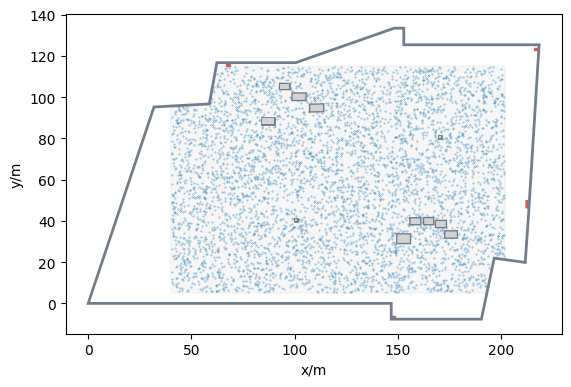

In [142]:
def plot_simulation_configuration(
    walkable_area, spawning_area, starting_positions, exit_areas
):
    fig, axes = plt.subplots(ncols=1, nrows=1)
    pedpy.plot_walkable_area(walkable_area=pedpy.WalkableArea(walkable_area),line_width=2, axes=axes)
    axes.fill(*intersection(spawning_area, walkable_area).exterior.xy, color="lightgrey", alpha=0.2)
    for exit_area in exit_areas:
        axes.fill(*exit_area.exterior.xy, color="indianred")
    axes.scatter(*zip(*starting_positions), s=0.1, alpha=0.7)
    axes.set_xlabel("x/m")
    axes.set_ylabel("y/m")
    axes.set_aspect("equal")
    fig.savefig(f"distribution_{len(starting_positions)}.pdf")
#spawning_area = walkable_area
pos_in_spawning_area = distribute_agents(num_agents=5000,seed=1, spawning_area=intersection(spawning_area, walkable_area))
plot_simulation_configuration(
    walkable_area, spawning_area, pos_in_spawning_area, exit_areas
)

In [143]:
def calculate_probability(point, time_elapsed, lambda_decay, time_scale):
    min_x, _, max_x, _ = walkable_area.bounds
    distance_to_left = point.x - min_x
    max_distance = max_x - min_x
    distance_factor = distance_to_left / max_distance
    normalized_time = time_elapsed / time_scale
    distance_factor = 1 - np.exp(-2*(distance_to_left / max_distance))
    probability = distance_factor * np.exp(-lambda_decay * normalized_time)
    #print(f"{time_elapsed=}, {normalized_time=}, {distance_factor=}, {probability=}")
    return probability

In [144]:
def get_nearest_exit_id(
    position: Point, exit_areas: List[Polygon], exit_ids: List[int]
) -> int:
    """Returns the nearest exit to the position."""
    min_distance = float("inf")
    selected_exit_id = None
    for exit_id, exit_area in zip(exit_ids, exit_areas):
        distance = Point(position).distance(exit_area)
        if distance < min_distance:
            min_distance = distance
            selected_exit_id = exit_id

    return selected_exit_id

In [145]:
def run_simulation(
    time_scale,
    lambda_decay,
    update_time,
    threshold,
    v0_max,
    seed,
    walkable_area,
    spawning_area,
    exit_areas,
    num_agents,
):
    trajectory_file = f"traj/trajectory_N{num_agents}_S{seed}_L{lambda_decay}.sqlite"
    spawning_area=intersection(spawning_area, walkable_area)
    pos_in_spawning_area = distribute_agents(num_agents=num_agents, seed=seed, spawning_area=spawning_area)
    print(f"lambda decay {lambda_decay}. num_agents: {len(pos_in_spawning_area)}")
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(),
        geometry=walkable_area,
        dt=0.05,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file)
        ),
    )

    exit_ids = []
    for exit_area in exit_areas:
        exit_id = simulation.add_exit_stage(exit_area)
        exit_ids.append(exit_id)

    journey_id = simulation.add_journey(jps.JourneyDescription(exit_ids))
    num_agents = len(pos_in_spawning_area)
    v_distribution = normal(v0_max, 0.05, num_agents)
    for pos, v0 in zip(pos_in_spawning_area, v_distribution):
        simulation.add_agent(
            jps.CollisionFreeSpeedModelAgentParameters(
                journey_id=journey_id,
                stage_id=get_nearest_exit_id(pos, exit_areas, exit_ids),
                position=pos,
                v0=v0,
                radius=0.15,
            )
        )

    
    dont_stop = True
    while simulation.agent_count() > 0 and dont_stop:
        simulation.iterate()
        if simulation.elapsed_time() % update_time < 0.01:
            print(f"Iteration: {simulation.iteration_count()}")
            dont_stop = False
            for agent in simulation.agents():
                prob = calculate_probability(
                    Point(agent.position), simulation.elapsed_time(), lambda_decay, time_scale
                )
                agent.model.v0 *= prob
                print(simulation.iteration_count(), agent.model.v0
                      )
                if agent.model.v0 > threshold and not dont_stop:
                    dont_stop = True
                    # print(simulation.iteration_count(), agent.model.v0)

    print(
        f"evacuation time: {simulation.iteration_count() * simulation.delta_time():.2f} s. Still in: {simulation.agent_count()}"
    )

    return (
        simulation.iteration_count() * simulation.delta_time(),
        simulation.agent_count(),
    )

In [146]:
num_agents = 5000
time_scale = 10#600  # in seconds = 10 min of shooting
update_time = 20  # in seconds
speed_threshold = 0.1  #  below this is dead / m/s 
v0_max = 3  # m/s
num_reps = 1
evac_times = {}
lambda_decays = [2]
dead = {}

for lambda_decay in lambda_decays:
    res = Parallel(n_jobs=1)(
        delayed(run_simulation)(
            time_scale=time_scale,
            lambda_decay=lambda_decay,
            update_time=update_time,
            threshold=speed_threshold,
            v0_max=v0_max,
            seed=1,#random.randint(1, 10000),
            walkable_area=walkable_area,
            spawning_area=spawning_area,
            exit_areas=exit_areas,
            num_agents=num_agents
        )
        for _ in range(num_reps)
    )
    res = np.array(res)
    evac_times[lambda_decay] = res[:,0]
    dead[lambda_decay] = res[:,1]


lambda decay 2. num_agents: 5000
Iteration: 400
400 0.02876835430434734
400 0.0351968222022444
400 0.025925982668201886
400 0.03003912004121588
400 0.028245585863822018
400 0.022842154654920538
400 0.030240305820623446
400 0.025073234639078755
400 0.04890678869014183
400 0.02631708189041545
400 0.04704361718667472
400 0.03521488654080931
400 0.02419103797318484
400 0.04037143618954922
400 0.04531170423271626
400 0.02197231327916014
400 0.02656279946803338
400 0.025541786041198257
400 0.039339275884516904
400 0.023252833764068368
400 0.02619512784379861
400 0.04190573374495569
400 0.04086820795868547
400 0.033916903546929986
400 0.024347456373764797
400 0.04113969390903281
400 0.02406886411999369
400 0.04479037549547375
400 0.04538520542845531
400 0.04669399964935026
400 0.039355964058966325
400 0.047514478401524604
400 0.04573510947938379
400 0.04590659468318908
400 0.04733760439490963
400 0.028916494036481173
400 0.045230431201167404
400 0.031050386770778315
400 0.03997804414437679
40

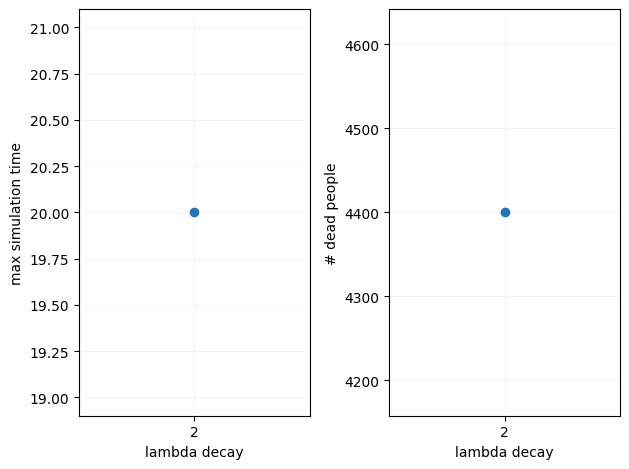

In [147]:
#lambda_decays = [1, 5, 10]
mean_evac_times = {scenario: np.mean(times) for scenario, times in evac_times.items()}
std_dev_evac_times = {scenario: np.std(times) for scenario, times in evac_times.items()}

mean_dead = {scenario: np.mean(dead) for scenario, dead in dead.items()}
std_dead = {scenario: np.std(dead) for scenario, dead in dead.items()}

means = [mean_evac_times[scenario] for scenario in lambda_decays]
std_devs = [std_dev_evac_times[scenario] for scenario in lambda_decays]

means1 = [mean_dead[scenario] for scenario in lambda_decays]
std_devs1 = [std_dead[scenario] for scenario in lambda_decays]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.errorbar(lambda_decays, means, yerr=std_devs, fmt="o-", ecolor="blue")

ax1.set_xlabel("lambda decay")
ax1.set_ylabel("max simulation time")

ax2.errorbar(lambda_decays, means1, yerr=std_devs1, fmt="o-", ecolor="red")
ax2.set_xlabel("lambda decay")
ax2.set_ylabel("# dead people")
ax2.set_xticks(lambda_decays)
ax1.set_xticks(lambda_decays)
ax2.grid(alpha=0.1)
ax1.grid(alpha=0.1)
plt.tight_layout()
plt.show()

In [148]:
#from jupedsim.internal.notebook_utils import animate, read_sqlite_file
#trajectory_file = "traj/trajectory_N1_S1_L1.sqlite"
#trajectory_data, walkable_area3 = read_sqlite_file(trajectory_file)

In [149]:
#animate(trajectory_data, walkable_area3)

In [150]:
# df = trajectory_data.data
# # Step 1: Filter to the last frame
# last_frame = df["frame"].max()
# last_frame_data = df[df["frame"] == last_frame]
# # Step 2: Check if each agent in the last frame is within the walkable area
# # Assuming walkable_area is a Shapely Polygon

# in_walkable_area = last_frame_data.apply(
#     lambda row: walkable_area.contains(Point(row["x"], row["y"])), axis=1
# )

# # Step 3: Count the number of agents in the walkable area
# agents_in_walkable_area = in_walkable_area.sum()
# print(f"Agents still in the area (probably dead by now): {agents_in_walkable_area}")

<>:47: SyntaxWarning: invalid escape sequence '\l'
<>:47: SyntaxWarning: invalid escape sequence '\l'
/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_91083/3798206545.py:47: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(p[lambda_decay], label=f"$\lambda$ = {lambda_decay}", lw=2)


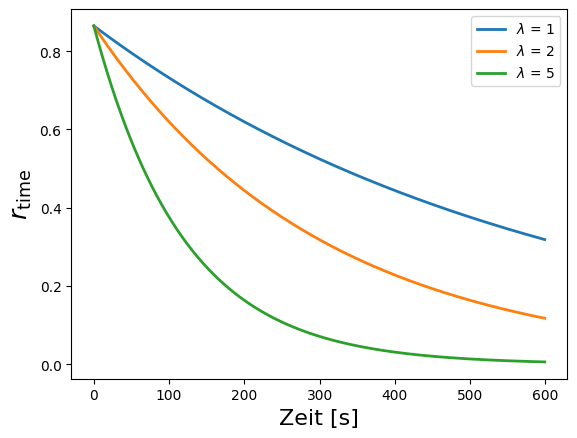

In [151]:
polygon = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])


# Function to generate a random point within a polygon
def random_point_in_polygon(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    while True:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if poly.contains(point):
            return point


# Distribute agents
num_agents = 10
lambda_decay = 10
agents = [random_point_in_polygon(polygon) for _ in range(num_agents)]
min_x, min_y, max_x, max_y = walkable_area.bounds
# Calculate initial probabilities
time_elapsed = 0
time_scale = 10 * 60  # in seconds
probabilities0 = [
    calculate_probability(agent, time_elapsed, lambda_decay, time_scale)
    for agent in agents
]
agent = Point(max_x, min_y)
probabilities0 = calculate_probability(agent, time_elapsed, lambda_decay, time_scale)
# Update probabilities over time
# For demonstration, let's say time_elapsed increases
p = [probabilities0]
p = {}
lambdas = [1, 2, 5]
for lambda_decay in lambdas: 
    p[lambda_decay] = []
for lambda_decay in lambdas:
    time_elapsed = 0
    while time_elapsed < time_scale:
    
        # probabilities1 = [
        #     calculate_probability(agent, time_elapsed, lambda_decay, time_scale)
        #     for agent in agents
        # ]
        probabilities = calculate_probability(agent, time_elapsed, lambda_decay, time_scale)
        time_elapsed += 1  # Increment time
        p[lambda_decay].append(probabilities)

for lambda_decay in lambdas:
    plt.plot(p[lambda_decay], label=f"$\lambda$ = {lambda_decay}", lw=2)

plt.ylabel("$r_{\\rm time}$", fontsize=18)
plt.xlabel("Zeit [s]", fontsize=16)
plt.legend()

In [152]:
np.exp(-1)

np.float64(0.36787944117144233)

png/heatmap_time_000.png


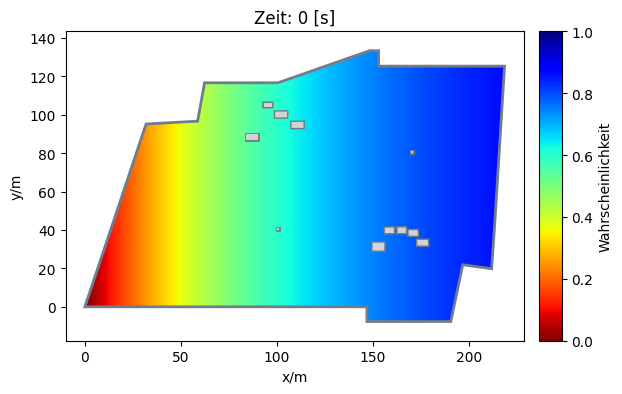

In [153]:
min_x, min_y, max_x, max_y = walkable_area.bounds

# Grid resolution
x_resolution = 350
y_resolution = 350

# Time points
time_points = [1, 5, 10]  # Example time points
# lambda_decay = 1  # Example lambda_decay value
# time_scale = 5  # Example time_scale

# Generate grid points
x = np.linspace(min_x, max_x, x_resolution)
y = np.linspace(min_y, max_y, y_resolution)
xx, yy = np.meshgrid(x, y)
grid_points = np.vstack((xx.flatten(), yy.flatten())).T

lambda_decay = 2 #0.5 1, 2
# Plotting heat maps
for time in [0]:#range(0, time_scale+10, 10):
    probabilities = [
        calculate_probability(Point(px, py), time, lambda_decay, time_scale)
        if walkable_area.contains(Point(px,py)) else np.nan
        for px, py in grid_points 
    ]
    prob_matrix = np.reshape(probabilities, (x_resolution, y_resolution))

    plt.figure()
    ax = plt.gca()
    cmap = copy.copy(plt.cm.jet_r)  # Or use any other colormap
    cmap.set_bad(color='white')
    im = ax.imshow(
        prob_matrix,
        extent=(min_x, max_x, min_y, max_y),
        origin="lower",
        vmin=0,
        vmax=1,
        cmap=cmap,
    )
    pedpy.plot_walkable_area(walkable_area=pedpy.WalkableArea(walkable_area), ax=ax,line_width=2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    # colorbar(label='Probability')
    plt.colorbar(im, cax=cax, label='Wahrscheinlichkeit')
    ax.set_title(f"Zeit: {time:d} [s]")
    #plt.xlabel(r"$\lambda$")
    #plt.ylabel("Y Coordinate")
    ax.set_xlim([min_x-10, max_x+10])
    ax.set_ylim([min_y-10, max_y+10])
    plt.savefig(f"png/heatmap_time_{time:03d}.png");  # Save the figure
    print(f"png/heatmap_time_{time:03d}.png")

In [154]:
print(f"{1:03d}")

001


In [155]:
time_scale

600

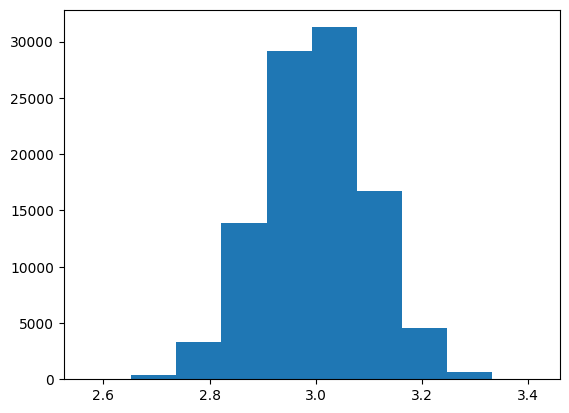

In [156]:

l = [ normal(3, 0.1) for _ in range(100000)]
plt.hist(l);

Text(0.5, 1.0, '$\\lambda$: 1, Aktualisierungszeit: 60 [s]')

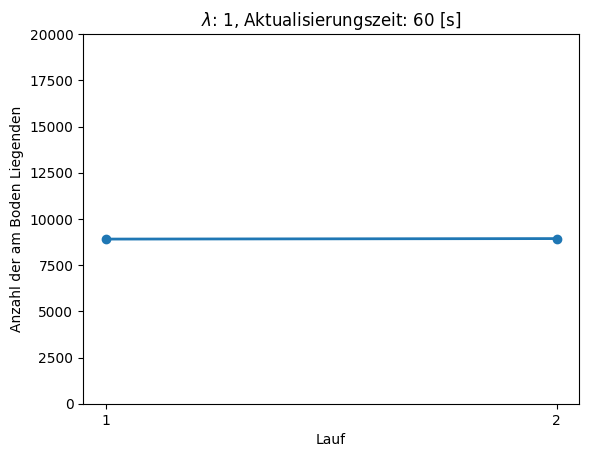

In [157]:
title  = r"$\lambda$: 1, Aktualisierungszeit: 60 [s]"
n = [8909, 8936]
plt.plot(n, "o-", lw=2)
plt.ylim([0, 20000])
plt.ylabel("Anzahl der am Boden Liegenden")
plt.xlabel("Lauf")
plt.xticks([0, 1], (1,2))
plt.title(title)